# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

# my imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, LambdaCallback

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# http://ufldl.stanford.edu/housenumbers/train.tar.gz
# http://ufldl.stanford.edu/housenumbers/test.tar.gz

In [3]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
! ls -lh

total 8.0K
drwx------ 6 root root 4.0K Jun 16 18:19 gdrive
drwxr-xr-x 1 root root 4.0K Jun 15 13:42 sample_data


In [5]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/Colab Notebooks/data/train_32x32.mat')
test  = loadmat('/content/gdrive/MyDrive/Colab Notebooks/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [6]:
X_train = train['X']
y_train = train['y']

X_test = test['X']
y_test = test['y']

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


In [8]:
# scale the values
X_train = X_train / 255.
X_test = X_test / 255.

# make the labels go from 0 - 9 (currently they go from 1 - 10)
# this means an image of the number zero is originally
# labeled as 10 - we want it to be 0
y_train = (train['y'] % 10)
y_test = (test['y'] % 10)

In [9]:
samples_n = 12
samples_idx = np.random.randint(0, X_train.shape[3], size=samples_n)

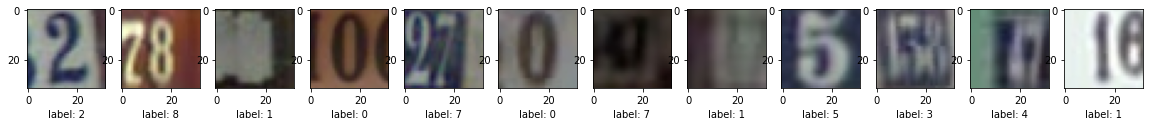

In [10]:
fig, ax = plt.subplots(1, samples_n, figsize=(20, 10))

for i, idx in enumerate(samples_idx):
    ax[i].imshow(X_train[:,:,:,idx])
    ax[i].set_xlabel(f'label: {y_train[idx,0]}')
    # ax[i].set_axis_off()

In [11]:
X_train_scaled = np.mean(X_train, axis=2, keepdims=True)
print(X_train_scaled.shape)
X_train_scaled = np.transpose(X_train_scaled, [3,0,1,2])
print(X_train_scaled.shape)

(32, 32, 1, 73257)
(73257, 32, 32, 1)


In [12]:
X_test_scaled = np.mean(X_test, axis=2, keepdims=True)
X_test_scaled = np.transpose(X_test_scaled, [3,0,1,2])
print(X_test_scaled.shape)

(26032, 32, 32, 1)


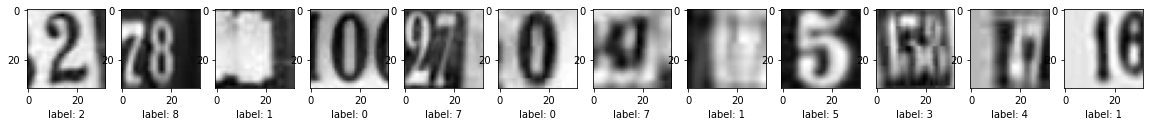

In [13]:
fig, ax = plt.subplots(1, samples_n, figsize=(20, 10))

for i, idx in enumerate(samples_idx):
    ax[i].imshow(X_train_scaled[idx,:,:,0], cmap='gray')
    # ax[i].set_axis_off()
    ax[i].set_xlabel(f'label: {y_train[idx, 0]}')


In [14]:
y_train = (train['y'] % 10)
y_test = (test['y'] % 10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
# print(type(X_train_scaled), X_train_scaled.shape)
# print(type(X_test_scaled), X_test_scaled.shape)
# print(type(y_train), y_train.shape)
# print(type(y_test), y_train.shape)

# print(type(y_train[0,0]), y_train[0,:])
# print(type(y_test[0,0]), y_test[0,:])

# for categorical crossentropy
# <class 'numpy.ndarray'> (73257, 32, 32, 1)
# <class 'numpy.ndarray'> (26032, 32, 32, 1)
# <class 'numpy.ndarray'> (73257, 10)
# <class 'numpy.ndarray'> (73257, 10)
# <class 'numpy.float64'> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
# <class 'numpy.float64'> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

# for sparse categorical crossentropy
# <class 'numpy.ndarray'> (73257, 32, 32, 1)
# <class 'numpy.ndarray'> (26032, 32, 32, 1)
# <class 'numpy.ndarray'> (73257, 1)
# <class 'numpy.ndarray'> (73257, 1)
# <class 'numpy.uint8'> [0]
# <class 'numpy.uint8'> [4]

In [16]:
# checkpoint_callback = ModelCheckpoint()
def get_callbacks(model_name):

    modelcheckpoint = ModelCheckpoint(
        filepath='model_' + model_name + '_{val_accuracy:.3f}.hdf5',
        monitor='val_loss', 
        verbose=1,
        save_best_only=True)
    

    def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        elif epoch < 10:
            return lr * tf.math.exp(-0.1)
        elif epoch < 20:
            return lr * tf.math.exp(-0.2)
        elif lr < 0.0003:
            return lr
        elif epoch % 1 == 0:
            return lr * tf.math.exp(-0.3)
        else:
            return lr


    lambdaScheduler = LearningRateScheduler(scheduler, verbose=1)

    return modelcheckpoint, lambdaScheduler

In [17]:
def get_model():

    model_mlp = Sequential([
            Flatten(input_shape=(32,32,1)),
            Dense(256,activation='relu'),
            Dense(256,activation='relu'),
            Dense(128,activation='relu'),
            Dense(10,activation="softmax")
    ])

    return model_mlp

In [18]:
model_mlp = get_model()
model_mlp.summary()

adam = Adam(learning_rate=0.0005)
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

model_mlp.compile(
    optimizer=sgd,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 362,378
Trainable params: 362,378
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_mlp = model_mlp.fit(X_train_scaled, 
                    y_train, 
                    validation_split=0.10,
                    batch_size=16,
                    callbacks=[get_callbacks('mlp')],
                    epochs=30
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/30
4105/4121 [============================>.] - ETA: 0s - loss: 1.9236 - accuracy: 0.3199
Epoch 1: val_loss improved from inf to 1.58386, saving model to model_mlp_0.468.hdf5
4121/4121 [==============================] - 15s 3ms/step - loss: 1.9222 - accuracy: 0.3205 - val_loss: 1.5839 - val_accuracy: 0.4681 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/30
4118/4121 [============================>.] - ETA: 0s - loss: 1.3760 - accuracy: 0.5470
Epoch 2: val_loss improved from 1.58386 to 1.15573, saving model to model_mlp_0.628.hdf5
4121/4121 [==============================] - 13s 3ms/step - loss: 1.3758 - accuracy: 0.5470 - val_loss: 1.1557 - val_accuracy: 0.6284 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/30
4113/4121 [============================>.] - ETA: 0s - loss: 1.1968 - accuracy: 0.6179
Epoc

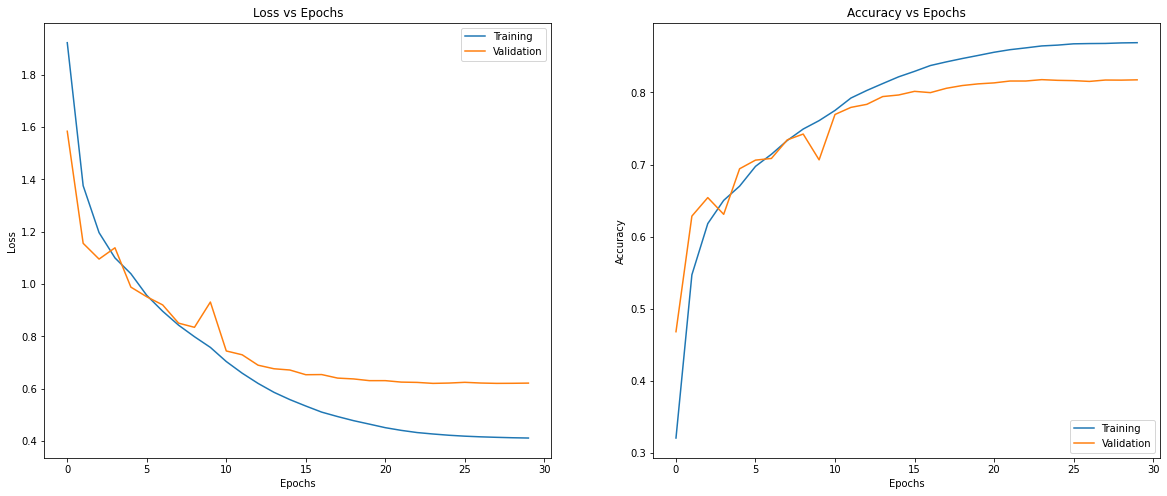

In [20]:
history_mlp.history.keys() # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

def plot_loss_accuracy(history):
    fig, axes = plt.subplots(1,2, figsize=(20,8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_xlabel(f'Epochs')
    axes[0].set_ylabel(f'Loss')
    axes[0].set_title(f'Loss vs Epochs')
    axes[0].legend(['Training', 'Validation'], loc='upper right')


    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    axes[1].plot(accuracy)
    axes[1].plot(val_accuracy)
    axes[1].set_xlabel(f'Epochs')
    axes[1].set_ylabel(f'Accuracy')
    axes[1].set_title(f'Accuracy vs Epochs')
    axes[1].legend(['Training', 'Validation'], loc='lower right')

plot_loss_accuracy(history_mlp)

In [21]:
model_mlp.evaluate(X_test_scaled, y_test)

814/814 [==============================] - 2s 2ms/step - loss: 0.7519 - accuracy: 0.7864


[0.7518965005874634, 0.7864167094230652]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
def get_CNN_model():

    model = Sequential([
        Conv2D(32, (3,3), input_shape=(32,32,1), activation='relu'),
        MaxPooling2D(pool_size=2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    return model

In [23]:
model_cnn = get_CNN_model()


model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)       

In [24]:
history_cnn = model_cnn.fit(
    X_train_scaled, 
    y_train, 
    validation_split=0.10,
    batch_size=32,
    callbacks=[get_callbacks('cnn')],
    epochs=15
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
2061/2061 [==============================] - ETA: 0s - loss: 0.8708 - accuracy: 0.7252
Epoch 1: val_loss improved from inf to 0.65149, saving model to model_cnn_0.790.hdf5
2061/2061 [==============================] - 22s 6ms/step - loss: 0.8708 - accuracy: 0.7252 - val_loss: 0.6515 - val_accuracy: 0.7905 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
2055/2061 [============================>.] - ETA: 0s - loss: 0.5329 - accuracy: 0.8392
Epoch 2: val_loss improved from 0.65149 to 0.58490, saving model to model_cnn_0.814.hdf5
2061/2061 [==============================] - 13s 6ms/step - loss: 0.5326 - accuracy: 0.8393 - val_loss: 0.5849 - val_accuracy: 0.8135 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
2060/2061 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.858

814/814 [==============================] - 3s 3ms/step - loss: 0.3129 - accuracy: 0.9123


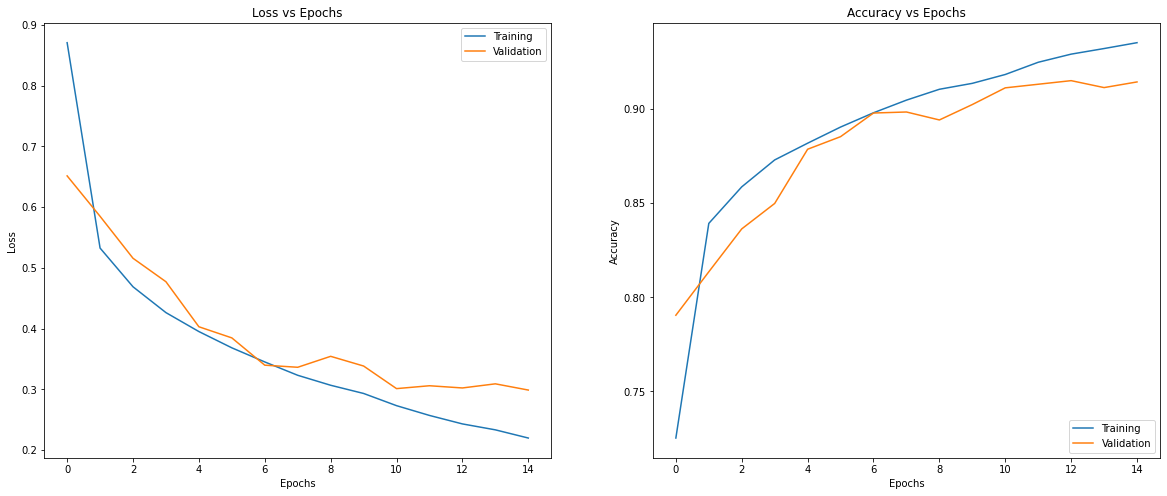

In [25]:
model_cnn.evaluate(X_test_scaled, y_test)
plot_loss_accuracy(history_cnn)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [27]:
# load the best models
best_mlp = tf.keras.models.load_model('model_mlp_0.818.hdf5')
best_cnn = tf.keras.models.load_model('model_cnn_0.914.hdf5')

In [28]:
num_images = 5
indexes = np.random.randint(0, X_train.shape[0], num_images)

In [29]:
# get predictions
predictions_mlp = best_mlp.predict(X_test_scaled[indexes, ...])
predictions_cnn = best_cnn.predict(X_test_scaled[indexes, ...])

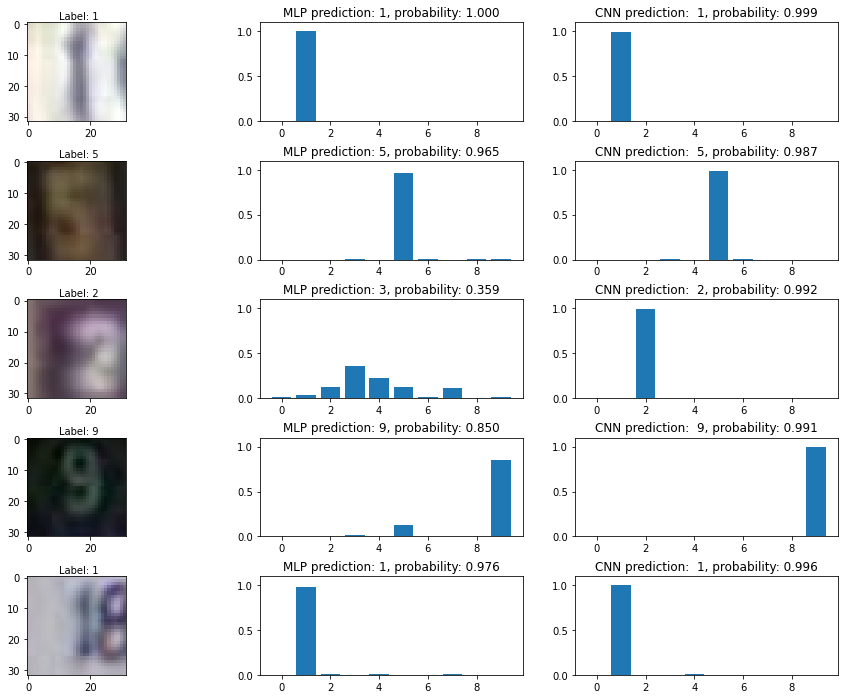

In [31]:
fig, ax = plt.subplots(num_images, 3, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for i, (idx, pred_mlp, pred_cnn) in enumerate(zip(indexes, predictions_mlp, predictions_cnn)):
    # show image 
    ax[i, 0].imshow(X_test[..., idx])
    ax[i, 0].text(10., -1.5, f'Label: {(y_test[idx, 0]) % 10}')


    # show distribution of predictions
    ax[i, 1].bar(np.arange(len(pred_mlp)), pred_mlp)
    ax[i, 1].set_title(f'MLP prediction: {np.argmax(pred_mlp)}, probability: {np.max(pred_mlp):.3f}')
    ax[i, 1].set_ylim([0, 1.1])

    ax[i, 2].bar(np.arange(len(pred_cnn)), pred_cnn)
    ax[i, 2].set_title(f'CNN prediction:  {np.argmax(pred_cnn)}, probability: {np.max(pred_cnn):.3f}')
    ax[i, 2].set_ylim([0, 1.1])
    

In [32]:
# evaluation of the mlp model with the random images
best_mlp.evaluate(X_test_scaled[indexes, ...], y_test[indexes,0])

1/1 [==============================] - 0s 109ms/step - loss: 0.4717 - accuracy: 0.8000


[0.47172659635543823, 0.800000011920929]

In [33]:
# evaluation of the cnn model with the random images
best_cnn.evaluate(X_test_scaled[indexes, ...], y_test[indexes,0])

1/1 [==============================] - 0s 154ms/step - loss: 0.0073 - accuracy: 1.0000


[0.0073150768876075745, 1.0]